In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [23]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import scipy, random, copy, h5py, pandas, math, csv, sys, os, pickle, re, json
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn import preprocessing
from numpy.random import RandomState
from scipy import ndimage
from scipy import stats
from scipy import ndimage
from datetime import datetime
path = os.getcwd()

sub_routines = os.path.join(path,'..','QueVasaEstudiar','python', 'sub_routines')
sys.path.append(sub_routines)
from neural_predictor import neural_predictor
from Import_MenuParameters import Import_MenuParameters

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
root = "C:/Users/Franco/GitHub" #Franco's MSI

csv_path = root + "/Bots_Colombia/data/"

def loadOutcomes():
    outcomes = {}
#    with open('python/Options_Outcomes_11_29_2017.csv') as csvfile:
    with open(root + '/QueVasaEstudiar/python/Options_Outcomes_05_15_2018.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            outcomes[int(row['Option_ID'])] = row
    return outcomes

outcomes = loadOutcomes()

def arange_outcomes(outcomes):

    HEOptions = {
    'MajorName'       : np.array([outcomes[x]['Option_Major_Name'] for x in outcomes.keys()]),
    'OptionID'        : np.array([x for x in outcomes.keys()]).astype(int),
    'InstCode'        : np.array([outcomes[x]['Option_Institution_Code'] for x in outcomes.keys()]).astype(int) -1,
    'Cutoff'          : np.array([outcomes[x]['LowerBoundScore'] for x in outcomes.keys()]).astype(float),
    'NoSearch'        : np.array([outcomes[x]['NoSearch'] for x in outcomes.keys()]).astype(int),
    'LevelCode'       : np.array([outcomes[x]['Option_Level_Code'] for x in outcomes.keys()]).astype(int) -1,
    'AreaCode'        : np.array([outcomes[x]['Option_Area_Code'] for x in outcomes.keys()]).astype(int) -1,
    'LocationCode'    : np.array([outcomes[x]['Option_Location_Code'] for x in outcomes.keys()]).astype(int) -1,
    'MajorCode'       : np.array([outcomes[x]['Option_Major_Code'] for x in outcomes.keys()]).astype(int) -1,
    'AverageEarning'  : np.array([outcomes[x]['Outcome_IncomeAve'] if outcomes[x]['Outcome_IncomeAve'] != "" else "-999" for x in outcomes.keys()]).astype(float)
    }

    HEOptions['AreaID']     = np.array(list(set(HEOptions['AreaCode'])))
    HEOptions['InstID']     = np.array(list(set(HEOptions['InstCode'])))      #We have to change this part
    HEOptions['LevelID']    = np.array(list(set(HEOptions['LevelCode'])))
    HEOptions['LocationID'] = np.array(list(set(HEOptions['LocationCode'])))
    HEOptions['MajorID']    = np.array(list(set(HEOptions['MajorCode'])))

    #Fixes:
    aux_InstID = np.array(range(HEOptions['InstID'].shape[0]))

    for y in HEOptions:
        HEOptions[y] = HEOptions[y][:,np.newaxis]

    for i in range(HEOptions['InstID'].shape[0]):
        HEOptions['InstCode'][HEOptions['InstCode'] == HEOptions['InstID'][i,0]] = aux_InstID[i]

    HEOptions['RelevantInst']  = aux_InstID[:,np.newaxis]
    HEOptions['normW']         = 10000000
    HEOptions['AverageEarning'][HEOptions['AverageEarning'] == -999] = np.nan

    return HEOptions


#1. Set up and import data:
#==========================

#1.1. Import Data:
HEOptions = arange_outcomes(outcomes)

with open(root+'/QueVasaEstudiar/interactions.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(";") for line in stripped if line)
    with open(root+'/QueVasaEstudiar/log.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerows(lines)

allinteractions = pd.read_csv(root+'/QueVasaEstudiar/log.csv', error_bad_lines=False)
allinteractions = allinteractions[(allinteractions.user != 'default-user') & (allinteractions.user.str.len() == 20)].reset_index(drop=True)

allinteractions["year"] = allinteractions.timestamp.str[0:4].astype(int)
allinteractions["month"] = allinteractions.timestamp.str[5:7].astype(int)
allinteractions["day"] = allinteractions.timestamp.str[8:10].astype(int)
allinteractions["second"] = allinteractions.timestamp.str[17:19].astype(int)
allinteractions["minute"] = allinteractions.timestamp.str[14:16].astype(int)
allinteractions["hour"] = allinteractions.timestamp.str[11:13].astype(int) - 7
allinteractions["hour"][allinteractions["hour"]==-7] = 17
allinteractions["hour"][allinteractions["hour"]==-6] = 18
allinteractions["hour"][allinteractions["hour"]==-5] = 19
allinteractions["hour"][allinteractions["hour"]==-4] = 20
allinteractions["hour"][allinteractions["hour"]==-3] = 21
allinteractions["hour"][allinteractions["hour"]==-2] = 22
allinteractions["hour"][allinteractions["hour"]==-1] = 23

allinteractions = allinteractions[(allinteractions.year == 2018) & (allinteractions.month >= 9)]
allinteractions = allinteractions[(allinteractions.user != "992") & (allinteractions.user != "YBOF9JBM8DE9ME6RE1K4") & (allinteractions.user != "EMF393CY0PX7ESW0BNQ")]

studentFeatures = pd.read_csv(root+'/QueVasaEstudiar/Student_Features_Fall2018.csv'.format(100))
interactionsBot = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/interactions_bot.csv'.format(100))
wageDeviation   = pd.read_csv(root+'/Bots_Colombia/ModelEstimation/deeplearning_estimation/wage_deviation.csv'.format(100)).drop(columns = ['Unnamed: 0']).rename(columns= {'studentID': 'user'})
interactions    = studentFeatures.merge(interactionsBot, left_on = 'Student_ID', right_on = 'Student_ID', how = 'left')


wageDeviation['hours'] = list(map(lambda x: x[0:10] + " " + x[11:13], wageDeviation['time']))
wageDeviation['hours'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H'), wageDeviation['hours']))
wageDeviation['times'] = list(map(lambda x: x[0:10] + " " + x[11:19], wageDeviation['time']))
wageDeviation['times'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), wageDeviation['times']))
wageDeviation['days'] = list(map(lambda x: x[0:10] , wageDeviation['time']))
wageDeviation['days'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), wageDeviation['days']))
wageDeviation['interaction'] = 1

allinteractions = allinteractions.sort_values(['month','day'])
allinteractions['Cummulative'] = np.cumsum(np.ones((allinteractions.shape[0],1))).astype(int)
allinteractions['Interacted'] = 1

allinteractions['times'] = list(map(lambda x: x[0:10] + " " + x[11:19], allinteractions['timestamp']))
allinteractions['times'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), allinteractions['times']))

allinteractions['hours'] = list(map(lambda x: x[0:10] + " " + x[11:13], allinteractions['timestamp']))
allinteractions['hours'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H'), allinteractions['hours']))

allinteractions['days'] = list(map(lambda x: x[0:10] , allinteractions['timestamp']))
allinteractions['days'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), allinteractions['days']))


wageDeviation['absWageDeviation'] = list(map(lambda x: abs(x), wageDeviation['wageDeviation']))


i = 1
j = 0
wageDeviation = wageDeviation.sort_values(by = ['user', 'times'])
wageDeviation['numberMenu'] = -999
for i in range(1,wageDeviation.shape[0]):
    if wageDeviation['user'].iloc[i] == wageDeviation['user'].iloc[i-1]:
        j += 1
        wageDeviation['numberMenu'].iloc[i] = j
    else:
        j = 1
        wageDeviation['numberMenu'].iloc[i] = j

wageDeviation['numberMenu'].iloc[0]=1
wageDeviation['numberMenu'][wageDeviation['numberMenu'] == 8] = 8
wageDeviation['numberMenu'][wageDeviation['numberMenu'] == 9] = 8
wageDeviation['numberMenu'][wageDeviation['numberMenu']>=10] = 9
wageDeviation['N_total']=1




# Chatbot Daily Progress

## Cummulative progress of the chatbot

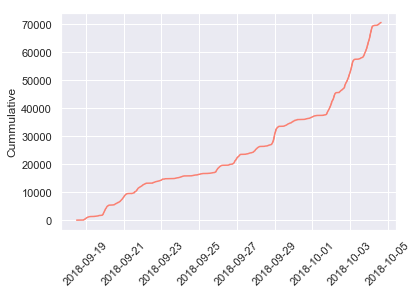

In [29]:
ax = sns.lineplot(x="times", y="Cummulative", data=allinteractions, color='salmon')
ax.set_xlabel('')
for tick in ax.get_xticklabels(): tick.set_rotation(45)

## Frequency of interactions

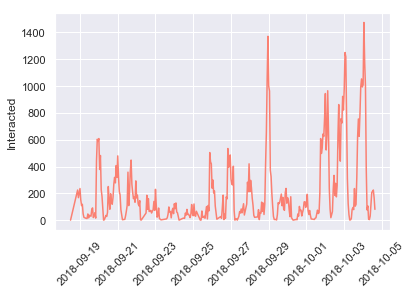

In [24]:
ax = sns.lineplot(x="hours", y="Interacted", data=allinteractions.groupby('hours').sum().reset_index(), color='salmon')
ax.set_xlabel('')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.show()

## Type of interaction by hour

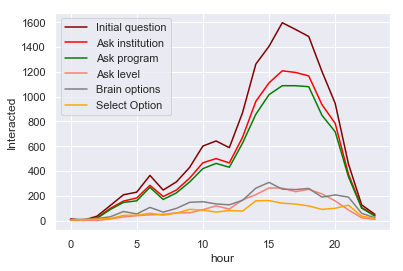

In [25]:
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'initialQuestion'].groupby('hour').sum().reset_index(), color='maroon', label='Initial question')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askInstitution'].groupby('hour').sum().reset_index(), color='red', label='Ask institution')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askCareer'].groupby('hour').sum().reset_index(), color='green', label='Ask program')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'askLevel'].groupby('hour').sum().reset_index(), color='salmon', label='Ask level')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'OPTIONS'].groupby('hour').sum().reset_index(), color='gray', label='Brain options')
ax = sns.lineplot(x="hour", y="Interacted", data=allinteractions[allinteractions['event_name'] == 'OPTIONS_SELECTION'].groupby('hour').sum().reset_index(), color='orange', label='Select Option')
plt.show()

## Wage deviation from true value by day

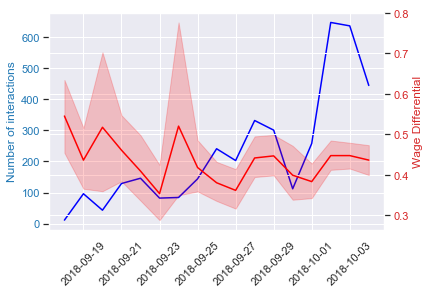

In [26]:
fig, ax1 = plt.subplots()
ax = sns.lineplot(x="days", y="interaction", data=wageDeviation[wageDeviation['days']<'2018-10-05 00:00:00'].groupby(['days']).sum().reset_index(), color='blue')
ax.set_xlabel('')
ax.set_ylabel('Number of interactions', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = sns.lineplot(x="days", y="absWageDeviation", data=wageDeviation[wageDeviation['days']<'2018-10-05 00:00:00'], color='red')
ax2.set_ylabel('Wage Differential', color='tab:red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='tab:red')
for tick in ax.get_xticklabels(): tick.set_rotation(45)
plt.show()

## Wage deviation from true value by number of menu interaction

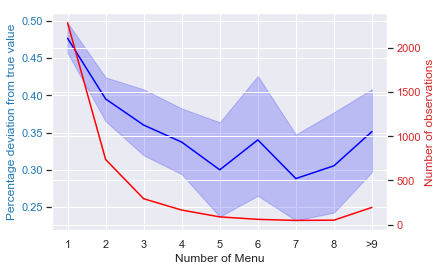

In [27]:
fig, ax = plt.subplots()
ax = sns.lineplot(x="numberMenu", y="absWageDeviation", data=wageDeviation[wageDeviation['days']<'2018-10-05 00:00:00'], color='blue')
ax.set_xlabel('Number of Menu')
ax.set_ylabel('Percentage deviation from true value', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = sns.lineplot(x="numberMenu", y="N_total", data=wageDeviation[wageDeviation['days']<'2018-10-05 00:00:00'].groupby(['numberMenu']).sum().reset_index(), color='red')
ax2.set_ylabel('Number of observations', color='tab:red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='tab:red')
labels = [int(x) for x in ax.get_xticks().tolist()]
labels[-2]='>9'
ax.set_xticklabels(labels)
plt.show()